In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, GlobalMaxPooling2D, BatchNormalization, Conv2D, MaxPooling2D, ReLU, GlobalAveragePooling2D
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight
from tensorflow.keras.utils import to_categorical

np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
! kaggle datasets download -d uraninjo/augmented-alzheimer-mri-dataset-v2

Dataset URL: https://www.kaggle.com/datasets/uraninjo/augmented-alzheimer-mri-dataset-v2
License(s): GNU Lesser General Public License 3.0
100% 378M/379M [00:21<00:00, 15.4MB/s]
100% 379M/379M [00:21<00:00, 18.6MB/s]


In [ ]:
# Put on the same directory
from zipfile import ZipFile

# specifying the name of the zip file
file = "augmented-alzheimer-mri-dataset-v2.zip"

# open the zip file in read mode
with ZipFile(file, 'r') as zip:
    # list all the contents of the zip file
    zip.printdir()

    # extract all files
    print('extraction...')
    zip.extractall()
    print('Done!')

In [ ]:
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
import albumentations as A
import cv2
from glob import glob
from tqdm import tqdm
import numpy as np


def create_dir(path):
    """ Create a directory. """
    if not os.path.exists(path):
        os.makedirs(path)


def augment_data(read_path, save_path, category = None, augment=True):
    """ Performing data augmentation. """
    H = 128
    W = 128

    augmentation_pipeline = A.Compose([

            # Add Augmentaion if you need, acutally we didn't augment the data

            ])

    for img in os.listdir(read_path):
        """ Extracting the dir name and image name """

        image_path = os.path.join(read_path,img)
        name = img.split(".")[0]


        """ Read the image """
        x = cv2.imread(image_path, cv2.IMREAD_COLOR)

        X = [x]


        if (augment == True) and category == 'MildDemented':

            for _ in range(6):
                augmented = augmentation_pipeline(image=x)
                X.append(augmented["image"])



        elif (augment == True) and category == 'ModerateDemented':

            for _ in range(100):
                augmented = augmentation_pipeline(image=x)
                X.append(augmented["image"])



        elif (augment == True) and category == 'VeryMildDemented':

             for _ in range(2):
                augmented = augmentation_pipeline(image=x)
                X.append(augmented["image"])



        elif (augment == True) and category == 'NonDemented':

             for _ in range(1):
                augmented = augmentation_pipeline(image=x)
                X.append(augmented["image"])



        idx = 0
        for i in X:
            i = cv2.resize(i, (W, H))

            if len(X) == 1:  # each loop it will take one image
                tmp_image_name = f"{name}.jpg"
            else:
                tmp_image_name = f"{name}_{idx}.jpg"

            image_path = os.path.join(save_path, tmp_image_name)

            cv2.imwrite(image_path, i)

            idx = idx + 1

In [ ]:
""" Create New directory for images """

test_dir_path = "data/val/"
classes = []
classes = os.listdir(test_dir_path)



for i in range(len(classes)):
    create_dir(os.path.join("new_data/train",classes[i]))

for i in range(len(classes)):
    create_dir(os.path.join("new_data/test",classes[i]))

for i in range(len(classes)):
    create_dir(os.path.join("new_data/val",classes[i]))

for i in range(len(classes)):
    create_dir(os.path.join("new_data/Aug_train",classes[i]))

In [ ]:
for i in range(len(classes)):
    augment_data(os.path.join(test_dir_path,classes[i]),
             os.path.join("new_data/test",classes[i]),augment=False)

/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:58: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
<ipython-input-7-6bf5f053fe92>:50: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), p=0.5),  # Add Gaussian noise


In [ ]:
dir_path = "data/train/"
classes = []
classes = os.listdir(dir_path)
print(classes)

['VeryMildDemented', 'MildDemented', 'NonDemented', 'ModerateDemented']


In [ ]:
NonDemented = os.listdir("data/train/NonDemented")
print(len(NonDemented))

MildDemented = os.listdir("data/train/MildDemented")
print(len(MildDemented))

VeryMildDemented = os.listdir("data/train/VeryMildDemented")
print(len(VeryMildDemented))

ModerateDemented = os.listdir("data/train/ModerateDemented")
print(len(ModerateDemented))

9600
8960
8960
6464


In [ ]:
import random
np.random.seed(42)
test_size = 0.2

val_of_NonDemented = random.sample(range(0, len(NonDemented)), int(test_size*len(NonDemented)))
val_of_MildDemented = random.sample(range(0, len(MildDemented)), int(test_size*len(MildDemented)))
val_of_VeryMildDemented = random.sample(range(0, len(VeryMildDemented)), int(test_size*len(VeryMildDemented)))
val_of_ModerateDemented = random.sample(range(0, len(ModerateDemented)), int(test_size*len(ModerateDemented)))

train_of_NonDemented = [num for num in range(0, len(NonDemented)) if num not in val_of_NonDemented]
train_of_MildDemented = [num for num in range(0, len(MildDemented)) if num not in val_of_MildDemented]
train_of_VeryMildDemented = [num for num in range(0, len(VeryMildDemented)) if num not in val_of_VeryMildDemented]
train_of_ModerateDemented = [num for num in range(0, len(ModerateDemented)) if num not in val_of_ModerateDemented]

In [ ]:
print(len(val_of_NonDemented))
print(len(val_of_MildDemented))
print(len(val_of_VeryMildDemented))
print(len(val_of_ModerateDemented))

print(len(train_of_NonDemented))
print(len(train_of_MildDemented))
print(len(train_of_VeryMildDemented))
print(len(train_of_ModerateDemented))

1920
1792
1792
1292
7680
7168
7168
5172


In [ ]:
def move_images(idx_list,read_path,write_path,data):
    for idx in idx_list:
        image_path = os.path.join(read_path,data[idx])
        name = data[idx]
        x = cv2.imread(image_path,cv2.IMREAD_COLOR)
        x = cv2.resize(x, (128, 128))

        image_write_path = os.path.join(write_path, name)
        cv2.imwrite(image_write_path, x)

In [ ]:
move_images(val_of_NonDemented,'data/train/NonDemented','new_data/val/NonDemented',NonDemented)
move_images(val_of_MildDemented,'data/train/MildDemented','new_data/val/MildDemented',MildDemented)
move_images(val_of_VeryMildDemented,'data/train/VeryMildDemented','new_data/val/VeryMildDemented',VeryMildDemented)
move_images(val_of_ModerateDemented,'data/train/ModerateDemented','new_data/val/ModerateDemented',ModerateDemented)

In [ ]:
print(len(os.listdir('new_data/val/NonDemented')),
len(os.listdir('new_data/val/MildDemented')),
len(os.listdir('new_data/val/VeryMildDemented')),
len(os.listdir('new_data/val/ModerateDemented')))

1920 1792 1792 1292


In [ ]:
move_images(train_of_NonDemented,'data/train/NonDemented','new_data/train/NonDemented',NonDemented)
move_images(train_of_MildDemented,'data/train/MildDemented','new_data/train/MildDemented',MildDemented)
move_images(train_of_VeryMildDemented,'data/train/VeryMildDemented','new_data/train/VeryMildDemented',VeryMildDemented)
move_images(train_of_ModerateDemented,'data/train/ModerateDemented','new_data/train/ModerateDemented',ModerateDemented)

In [ ]:
print(len(os.listdir('new_data/train/NonDemented')),
len(os.listdir('new_data/train/MildDemented')),
len(os.listdir('new_data/train/VeryMildDemented')),
len(os.listdir('new_data/train/ModerateDemented')))

7680 7168 7168 5172


In [ ]:
""" Move images to the new directory and augment (optional)"""

augment_data("new_data/train/VeryMildDemented",
             "new_data/Aug_train/VeryMildDemented",category = 'VeryMildDemented',augment=False)

print(len(os.listdir("new_data/Aug_train/VeryMildDemented")))

In [ ]:
augment_data("new_data/train/NonDemented",
             "new_data/Aug_train/NonDemented",category = 'NonDemented',augment=False)

print(len(os.listdir("new_data/Aug_train/NonDemented")))

In [ ]:
augment_data("new_data/train/MildDemented",
             "new_data/Aug_train/MildDemented",category = 'MildDemented',augment=False)

print(len(os.listdir("new_data/Aug_train/MildDemented")))

In [ ]:
augment_data("new_data/train/ModerateDemented",
             "new_data/Aug_train/ModerateDemented",category = 'ModerateDemented',augment=False)

print(len(os.listdir("new_data/Aug_train/ModerateDemented")))

In [ ]:

train_path = r'new_data/Aug_train/'
val_path = r'new_data/val/'
test_path = r'new_data/test/'

train_datagen = ImageDataGenerator(rescale = 1/255.0)

val_datagen = ImageDataGenerator(rescale = 1/255.0)

test_datagen = ImageDataGenerator(rescale = 1/255.0)


train_batches = train_datagen.flow_from_directory(directory = train_path,
                target_size = (128,128), batch_size = 32, class_mode='categorical', shuffle=True)

valid_batches = val_datagen.flow_from_directory(directory = val_path,
                target_size = (128,128), batch_size = 32, class_mode='categorical', shuffle=False)

test_batches = test_datagen.flow_from_directory(directory = test_path,
                target_size = (128,128), batch_size = 32, class_mode='categorical', shuffle=False)


Found 27188 images belonging to 4 classes.
Found 6796 images belonging to 4 classes.
Found 6400 images belonging to 4 classes.


In [ ]:
base_model = tf.keras.applications.ResNet50(input_shape=(128,128,3),
                   include_top=False,
                   weights='imagenet')
base_model.summary()

## you can train different pretrained models from the following

# MobileNet
# base_model = tf.keras.applications.MobileNetV2(input_shape=(128,128,3),
#                   include_top=False,
#                   weights='imagenet')


# Inception
# base_model = tf.keras.applications.InceptionV3(input_shape=(128,128,3),
#                   include_top=False,
#                   weights='imagenet')

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 134, 134, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 64, 64, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 64, 64, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 64, 64, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 66, 66, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 32, 32, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 32, 32, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 32, 32, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 32, 32, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 32, 32, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 32, 32, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 32, 32, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 32, 32, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 32, 32, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
output = Dense(4, activation='softmax')(x)

In [ ]:
model = Model(inputs=base_model.input, outputs=output)

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001),loss=categorical_crossentropy, metrics=['accuracy','recall', 'precision'])

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 134, 134, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 64, 64, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 64, 64, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 64, 64, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 66, 66, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 32, 32, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 32, 32, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 32, 32, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 32, 32, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 32, 32, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 32, 32, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 32, 32, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 32, 32, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 32, 32, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 25,689,988 (98.00 MB)

 Trainable params: 25,636,868 (97.80 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
from tensorflow.keras import backend as K

class ClearMemory(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        # Clear TensorFlow session to free up memory
        K.clear_session()
        print(f"Cleared memory after epoch {epoch + 1}")


clear_memory = ClearMemory()

In [ ]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='/content/drive/MyDrive/Alzheimer/best_model_Aug_version_ResNet.keras',       # Path to save model
    monitor='val_loss',             # Monitor validation loss
    save_best_only=True,            # Save only if the model does better
    mode='min',                     # Want to minimize the loss
    verbose=1,
)

In [ ]:
# Define a custom learning rate decay function
def exponential_decay(epoch, lr):
    decay_rate = 0.96  # Decay by 4% each epoch
    return lr * decay_rate

# Create the LearningRateScheduler callback
lr_callback = tf.keras.callbacks.LearningRateScheduler(exponential_decay)

In [ ]:
history = model.fit(train_batches,
          validation_data = valid_batches,
          batch_size = 32,
          callbacks=[clear_memory, checkpoint_callback, lr_callback],
          epochs=25)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
850/850 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.7194 - loss: 0.6508 - precision: 0.7745 - recall: 0.6510Cleared memory after epoch 1

Epoch 1: val_loss improved from inf to 0.93056, saving model to /content/drive/MyDrive/Alzheimer/best_model_Aug_version_ResNet.keras
850/850 ━━━━━━━━━━━━━━━━━━━━ 203s 166ms/step - accuracy: 0.7196 - loss: 0.6505 - precision: 0.7746 - recall: 0.6511 - val_accuracy: 0.7035 - val_loss: 0.9306 - val_precision: 0.7349 - val_recall: 0.6776 - learning_rate: 9.6000e-05
Epoch 2/25
850/850 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.9636 - loss: 0.0982 - precision: 0.9660 - recall: 0.9614Cleared memory after epoch 2

Epoch 2: val_loss improved from 0.93056 to 0.21239, saving model to /content/drive/MyDrive/Alzheimer/best_model_Aug_version_ResNet.keras
850/850 ━━━━━━━━━━━━━━━━━━━━ 118s 135ms/step - accuracy: 0.9636 - loss: 0.0982 - precision: 0.9660 - recall: 0.9614 - val_accuracy: 0.9216 - val_loss: 0.2124 - val_precision: 0.9235 - val_rec

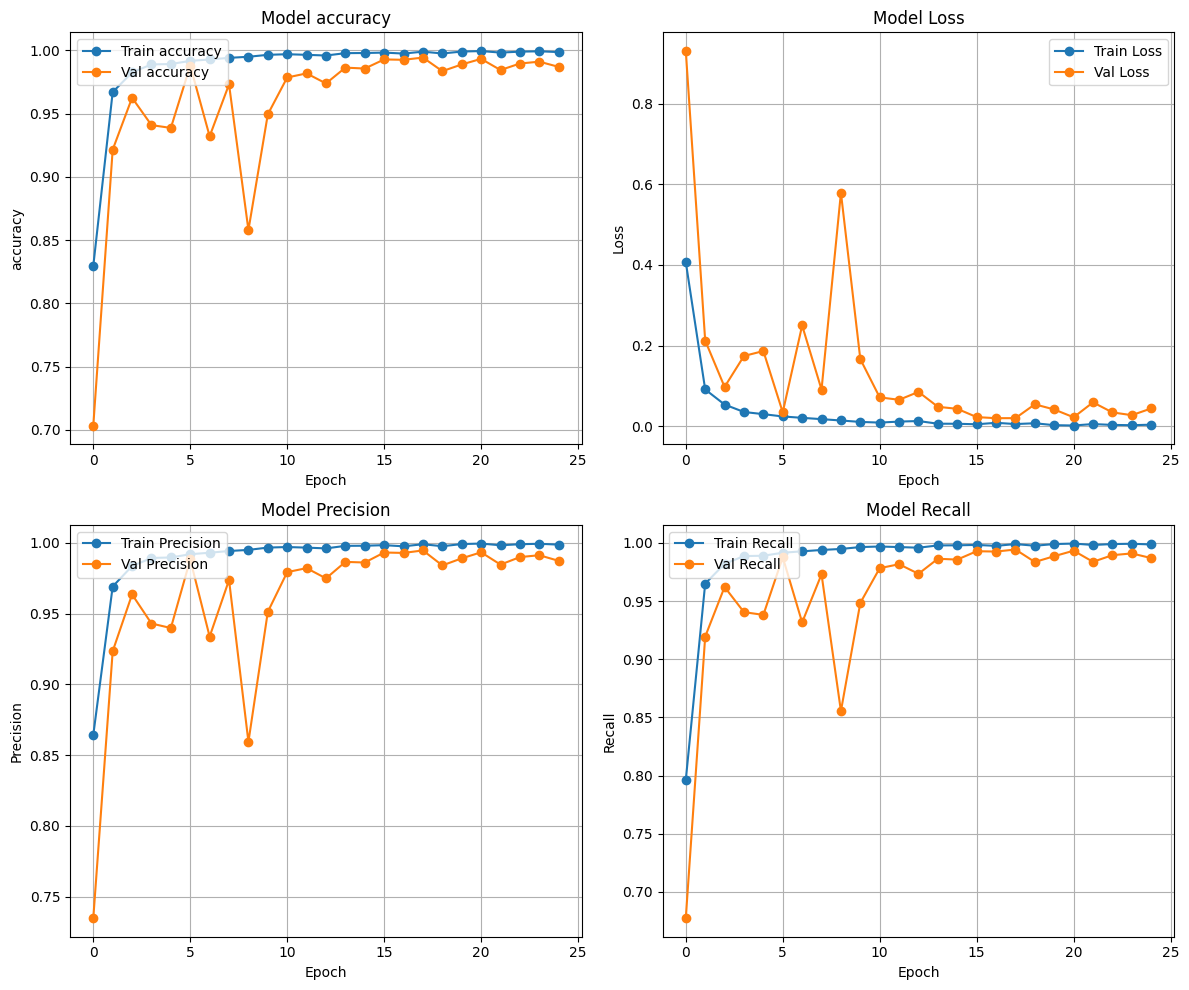

In [ ]:
import matplotlib.pyplot as plt

# Define a figure with an appropriate size
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot IoU
axes[0, 0].plot(history.history['accuracy'], label='Train accuracy', marker='o')
axes[0, 0].plot(history.history['val_accuracy'], label='Val accuracy', marker='o')
axes[0, 0].set_title('Model accuracy')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('accuracy')
axes[0, 0].legend(loc='upper left')
axes[0, 0].grid(True)

# Plot Loss
axes[0, 1].plot(history.history['loss'], label='Train Loss', marker='o')
axes[0, 1].plot(history.history['val_loss'], label='Val Loss', marker='o')
axes[0, 1].set_title('Model Loss')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend(loc='upper right')
axes[0, 1].grid(True)

# Plot Precision
axes[1, 0].plot(history.history['precision'], label='Train Precision', marker='o')
axes[1, 0].plot(history.history['val_precision'], label='Val Precision', marker='o')
axes[1, 0].set_title('Model Precision')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].legend(loc='upper left')
axes[1, 0].grid(True)

# Plot Recall
axes[1, 1].plot(history.history['recall'], label='Train Recall', marker='o')
axes[1, 1].plot(history.history['val_recall'], label='Val Recall', marker='o')
axes[1, 1].set_title('Model Recall')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Recall')
axes[1, 1].legend(loc='upper left')
axes[1, 1].grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()


In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/Alzheimer/best_model_Aug_version_ResNet.keras')
test_labels = test_batches.classes
len(test_labels)

6400

In [ ]:
preds = model.predict(x=test_batches,verbose=0)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


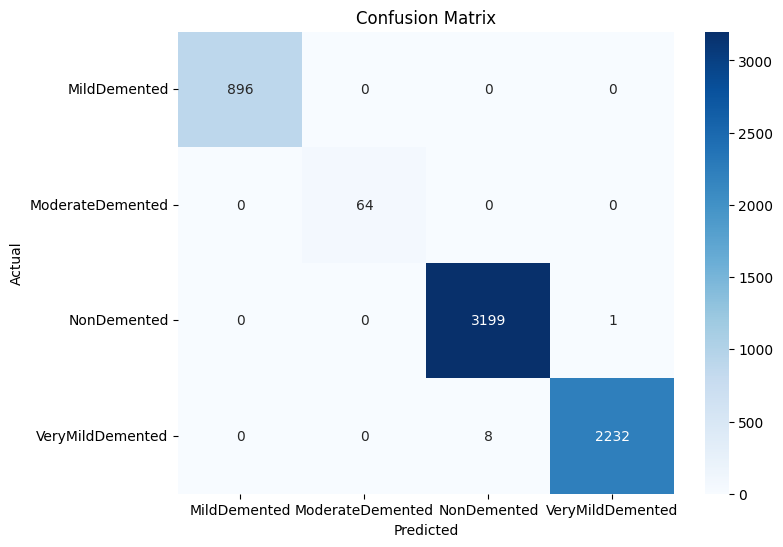

In [ ]:
import seaborn as sns
cm = confusion_matrix(y_true = test_batches.classes, y_pred = preds.argmax(axis=1))
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_batches.class_indices.keys(), yticklabels=test_batches.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
loss, accuracy, recall, pre = model.evaluate(test_batches)
print(f'Loss: {loss}, Accuracy: {accuracy}, recall: {recall}, precision: {pre} ')

200/200 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - accuracy: 0.9997 - loss: 0.0019 - precision: 0.9997 - recall: 0.9997
Loss: 0.0041579511016607285, Accuracy: 0.9985937476158142, recall: 0.9985937476158142, precision: 0.9985937476158142 


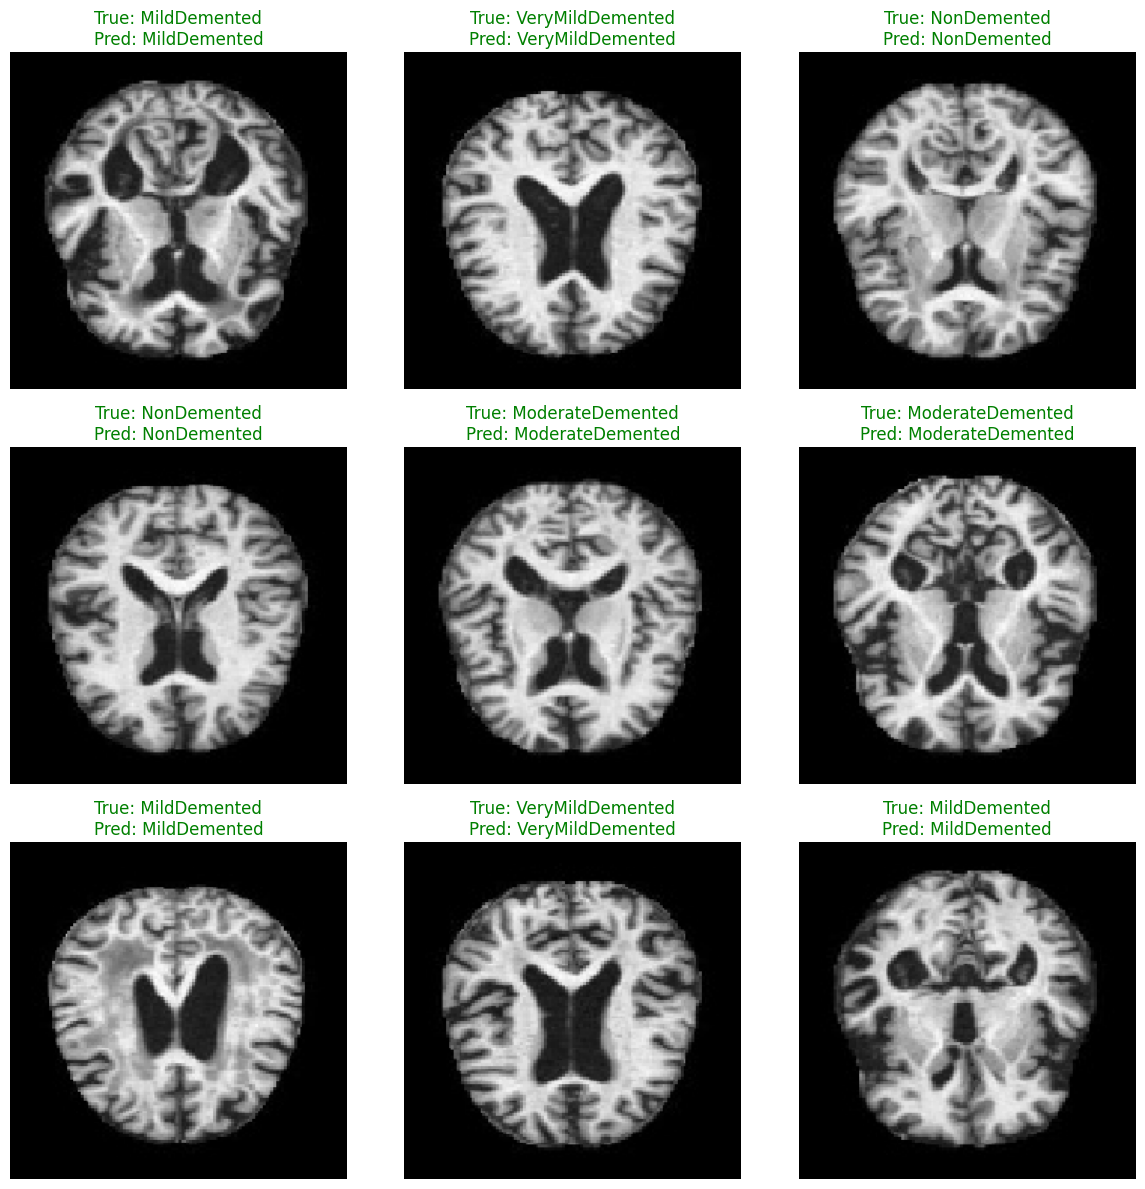

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Get class names and total number of classes
class_names = list(test_batches.class_indices.keys())
num_classes = len(class_names)
total_samples = 9  # adjust as needed

# Calculate base samples per class and extra samples needed
samples_per_class = total_samples // num_classes
extra_samples = total_samples % num_classes

selected_indices = []

# Collect indices from each class
for cls_idx in range(num_classes):
    # Get all indices for the current class
    cls_indices = np.where(test_labels == cls_idx)[0]

    if len(cls_indices) == 0:
        continue  # skip empty classes

    # Determine how many samples to take from this class
    n = samples_per_class + (1 if cls_idx < extra_samples else 0)
    n = min(n, len(cls_indices))  # avoid over-sampling

    # Randomly select indices
    selected = np.random.choice(cls_indices, size=n, replace=False)
    selected_indices.extend(selected)

# Handle cases where we still need more samples (e.g., small classes)
remaining = total_samples - len(selected_indices)
if remaining > 0:
    all_indices = np.arange(len(test_labels))
    remaining_indices = np.setdiff1d(all_indices, selected_indices)
    additional = np.random.choice(remaining_indices, size=remaining, replace=False)
    selected_indices.extend(additional)

# Shuffle to mix class order
np.random.shuffle(selected_indices)

# Visualize using file paths (avoids loading all images into memory)
plt.figure(figsize=(12, 12))
for i, idx in enumerate(selected_indices[:total_samples]):
    plt.subplot(3, 3, i+1)

    # Load image directly from test generator's file paths
    img_path = test_batches.filepaths[idx]
    img = tf.keras.utils.load_img(img_path, target_size=(224, 224))
    img_array = tf.keras.utils.img_to_array(img) / 255.0  # match preprocessing

    # Get predictions and labels
    true_class = test_labels[idx]
    true_label = class_names[true_class]
    pred_label = class_names[preds[idx].argmax()]

    # Display
    plt.imshow(img_array)
    color = 'green' if true_label == pred_label else 'red'
    plt.title(f"True: {true_label}\nPred: {pred_label}", color=color)
    plt.axis('off')

plt.tight_layout()
plt.show()